<a href="https://colab.research.google.com/github/vasvarym/FakeNewsProject/blob/main/nelasentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
import re
import matplotlib.pyplot as plt
# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import nltk
import nltk.corpus
import string
from gensim.models.word2vec import Word2Vec
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

In [40]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [41]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

#Import Dataset

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
data = pd.read_csv("/content/drive/My Drive/nela10sample.csv")
data.content=data.content.astype(str)
data.title=data.title.astype(str)

In [44]:
# Change labels
def change_labels(y):
    if y == 0:
        return 0
    if y == 2:
        return 1

In [ ]:
data

In [45]:
# Shape of each set

print("Shape of DATA: ", data.shape)

Shape of DATA:  (102554, 11)


In [46]:
# Concetanate title and content
data["content"] = data["title"] + " " + data["content"]

#Keep only content, Reliability as columns
data = data.drop(['id','date','source','title','author','url','published','published_utc','collection_utc'],axis=1)

In [ ]:
data

# Sentiment Analysis

Get polarity and subjectivity scores of the news with TextBlob

In [47]:
# Import the TextBlob
from textblob import TextBlob

In [48]:
df1 = data[:1000]
df2 = data[-1000:]
df3 = [df1,df2]
smallerdf = pd.concat(df3)

In [49]:
smallerdf["Reliability"] = smallerdf.Reliability.apply(change_labels)

print(smallerdf["Reliability"])

0         0
1         0
2         0
3         0
4         0
         ..
102549    1
102550    1
102551    1
102552    1
102553    1
Name: Reliability, Length: 2000, dtype: int64


In [50]:
# Add polarities and subkectivities into the DataFrame by using TextBlob
smallerdf["Polarity"] = smallerdf["content"].apply(lambda word: TextBlob(word).sentiment.polarity)
smallerdf["Subjectivity"] = smallerdf["content"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns of train dataset
display(smallerdf[["content","Polarity","Subjectivity"]].head(10))

,content,Polarity,Subjectivity
0,Students could take SAT at home if schools rem...,0.079265,0.395490
1,Detroit facing fresh fiscal woes with coronavi...,0.072199,0.433984
2,Thousands protest Michigan governor's social d...,-0.072874,0.411442
3,Baltimore Police defends planned aerial survei...,0.033147,0.602930
4,Attorney who fought for civil rights in Louisi...,0.185473,0.484764
5,California to give cash payments to immigrants...,0.096134,0.421376
6,Deputies: Florida doctors who took down Trump ...,-0.031313,0.246465
7,Evidence of virus' effect on US economy grows ...,0.110147,0.393699
8,Lawyer for Hanukkah stabbing suspect seeks to ...,-0.114876,0.404959
9,Explosion caught on video damages paper mill; ...,-0.034538,0.497237


In [ ]:
# Define a function to classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
smallerdf["SentLabel"] = smallerdf["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(smallerdf[["SentLabel"]].head(10))

,SentLabel
0,Positive
1,Positive
2,Negative
3,Positive
4,Positive
5,Positive
6,Negative
7,Positive
8,Negative
9,Negative


In [ ]:
# Print the value counts of the SentLabel column
print(smallerdf["SentLabel"].value_counts())

Positive    1379
Negative     584
Neutral       37
Name: SentLabel, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


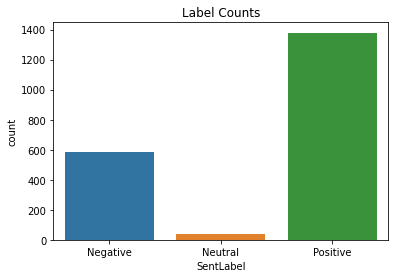

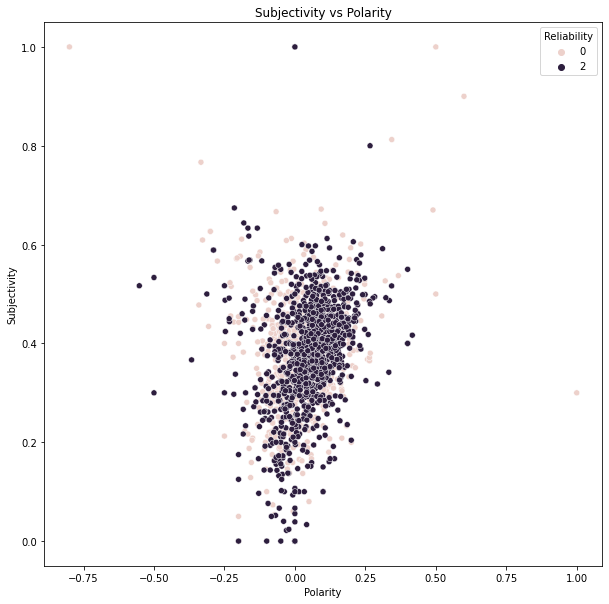

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Change the datatype as "category"
smallerdf["SentLabel"] = smallerdf["SentLabel"].astype("category")

# Visualize the Label counts
sns.countplot(smallerdf["SentLabel"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Reliability", data=smallerdf)
plt.title("Subjectivity vs Polarity")
plt.show()

# Emotion Analysis

In [51]:
#Install package using pip
!pip install text2emotion

In [52]:
#Import the modules
import text2emotion as te

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
emodf = data[:10]

In [79]:
emodf['Emotions'] = emodf['content'].apply(te.get_emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
emodf['Emotions'][0]['Happy']

0.16

In [83]:
newdf = pd.DataFrame(emodf['Emotions'].tolist())

In [84]:
newdf

,Happy,Angry,Surprise,Sad,Fear
0,0.16,0.03,0.17,0.14,0.50
1,0.07,0.09,0.18,0.20,0.46
2,0.07,0.06,0.20,0.24,0.43
3,0.12,0.00,0.12,0.17,0.57
4,0.09,0.03,0.24,0.14,0.49
5,0.04,0.02,0.22,0.32,0.40
6,0.05,0.00,0.47,0.21,0.26
7,0.06,0.05,0.14,0.14,0.62
8,0.27,0.00,0.13,0.27,0.33
9,0.10,0.09,0.32,0.25,0.24


In [56]:
emodf['Happy'] = emodf.Emotions.str.slice(10,13).astype(float)
emodf['Angry'] = emodf.Emotions.str.slice(24,28).astype(float)
emodf['Surprise'] = emodf.Emotions.str.slice(42,46).astype(float)
emodf['Sad'] = emodf.Emotions.str.slice(55,59).astype(float)
emodf['Fear'] = emodf.Emotions.str.slice(69,73).astype(float)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [57]:
emodf['Emotions'][0]

"{'Happy': 0.16, 'Angry': 0.03, 'Surprise': 0.17, 'Sad': 0.14, 'Fear': 0.5}"

In [58]:
emodf

,content,Reliability,Emotions,Happy,Angry,Surprise,Sad,Fear
0,Students could take SAT at home if schools rem...,0,"{'Happy': 0.16, 'Angry': 0.03, 'Surprise': 0.1...",0.1,0.00,0.10,0.10,0.50
1,Detroit facing fresh fiscal woes with coronavi...,0,"{'Happy': 0.07, 'Angry': 0.09, 'Surprise': 0.1...",0.0,0.00,0.10,0.20,0.46
2,Thousands protest Michigan governor's social d...,0,"{'Happy': 0.07, 'Angry': 0.06, 'Surprise': 0.2...",0.0,0.00,0.20,0.24,0.43
3,Baltimore Police defends planned aerial survei...,0,"{'Happy': 0.12, 'Angry': 0.0, 'Surprise': 0.12...",0.1,0.00,0.12,0.17,0.57
4,Attorney who fought for civil rights in Louisi...,0,"{'Happy': 0.09, 'Angry': 0.03, 'Surprise': 0.2...",0.0,0.00,0.20,0.10,0.40
5,California to give cash payments to immigrants...,0,"{'Happy': 0.04, 'Angry': 0.02, 'Surprise': 0.2...",0.0,0.00,0.20,0.30,0.40
6,Deputies: Florida doctors who took down Trump ...,0,"{'Happy': 0.05, 'Angry': 0.0, 'Surprise': 0.47...",0.0,0.00,0.47,0.21,0.26
7,Evidence of virus' effect on US economy grows ...,0,"{'Happy': 0.06, 'Angry': 0.05, 'Surprise': 0.1...",0.0,0.00,0.10,0.10,0.60
8,Lawyer for Hanukkah stabbing suspect seeks to ...,0,"{'Happy': 0.27, 'Angry': 0.0, 'Surprise': 0.13...",0.2,0.00,0.13,0.27,0.33
9,Explosion caught on video damages paper mill; ...,0,"{'Happy': 0.1, 'Angry': 0.09, 'Surprise': 0.32...",0.1,0.09,0.32,0.25,0.24


# Text-PreProcessing

In [59]:
def rem_noise(text):
  text = text.translate(str.maketrans('','',string.punctuation))

  text =  re.sub('[0-9]+','',text)

  text = re.sub('https?:\S+','',text)

  text =  re.sub('<.*?>'," ",text)

  return text

In [60]:
stop = set(stopwords.words('english'))

def rem_stopwords(text):
    
    words = [ch for ch in text if ch not in stop]
    words= "".join(words).split()
    words= [words.lower() for words in text.split()]
    
    return words

In [61]:
def tokenize_statements(text):
    
    # Tokenize the words
    tokenized = word_tokenize(text)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words, changing text to lowercase
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token.lower(), pos='a') for token in tokenized]
    
    return tokenized

#TF-IDF Vectorizer

In [ ]:
#Keep only content, Polarity and Subjectivity as columns
x = smallerdf.drop(['Reliability', 'Subjectivity'],axis=1)
x['content'] = x['content'].apply(rem_noise)
y = smallerdf['Reliability']

In [ ]:
# split the dataset into training and testing datasets 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1600, 3)
(1600,)
(400, 3)
(400,)


In [ ]:
X_train

,content,Polarity
760,Prosecutor Remains found in Phoenix were those...,-0.019147
101852,Hit hard by closures Tennessee tourist spots e...,0.079046
102147,San Francisco gets alcohol tobacco for addicts...,0.137500
591,Officials identify remains found in burntout H...,-0.007692
131,Mississippi lacking guards sends inmates to pr...,0.090206
...,...,...
101857,Police Bodies in vehicles outside Brooklyn fun...,0.118344
43,Things to Know for Today Your daily look at l...,0.004769
102213,Fairmont State offers virtual commencement thi...,0.333333
945,Coronavirus Trump says peak is passed and US t...,0.110798


In [ ]:
# Vectorize the text so the models can actually interpret it
vectorizer = TfidfVectorizer(tokenize_statements)
x_train_vectorized = vectorizer.fit_transform(X_train.content.values)
x_test_vectorized = vectorizer.transform(X_test.content.values)

In [ ]:
x_train_vectorized

<1600x28905 sparse matrix of type '<class 'numpy.float64'>'
	with 335575 stored elements in Compressed Sparse Row format>

In [ ]:
print (x_train_vectorized.shape)
print (x_test_vectorized.shape)
print (y_train.shape)
print (y_test.shape)

(1600, 28905)
(400, 28905)
(1600,)
(400,)


In [ ]:
type (X_train["Polarity"].values)

numpy.ndarray

In [ ]:
print (x_train_vectorized)

In [ ]:
x_train_pol = X_train["Polarity"]
x_test_pol = X_test["Polarity"]

x_train_pol.shape

(1600,)

In [ ]:
df_x_test_tfidf =  pd.DataFrame.sparse.from_spmatrix(x_test_vectorized)
df_x_test_tfidf['polarity'] = X_test['Polarity'].values

df_x_train_tfidf =  pd.DataFrame.sparse.from_spmatrix(x_train_vectorized)
df_x_train_tfidf['polarity'] = X_train['Polarity'].values

In [ ]:
df_x_test_tfidf['polarity']

0     -0.013885
1      0.005466
2      0.081024
3     -0.036871
4      0.144237
         ...   
395    0.107834
396    0.024249
397    0.111645
398    0.084069
399    0.079267
Name: polarity, Length: 400, dtype: float64

In [ ]:
df_x_train_tfidf_nopol = df_x_train_tfidf.drop(['polarity'],axis=1)
df_x_test_tfidf_nopol = df_x_test_tfidf.drop(['polarity'],axis=1)

In [ ]:
df_x_test_tfidf_nopol

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,28865,28866,28867,28868,28869,28870,28871,28872,28873,28874,28875,28876,28877,28878,28879,28880,28881,28882,28883,28884,28885,28886,28887,28888,28889,28890,28891,28892,28893,28894,28895,28896,28897,28898,28899,28900,28901,28902,28903,28904
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(df_x_train_tfidf, y_train)
logR_predicted = log_reg.predict(df_x_test_tfidf)
print(f"{log_reg.__class__.__name__} accuracy: {log_reg.score(df_x_test_tfidf, y_test)}")

LogisticRegression accuracy: 0.85


In [ ]:
log_reg_nopol = LogisticRegression()
log_reg_nopol.fit(df_x_train_tfidf_nopol, y_train)
logR_predicted = log_reg_nopol.predict(df_x_test_tfidf_nopol)
print(f"{log_reg_nopol.__class__.__name__} accuracy: {log_reg_nopol.score(df_x_test_tfidf_nopol, y_test)}")

LogisticRegression accuracy: 0.8375


In [ ]:
print(classification_report(y_test, logR_predicted))
print('\n')
print(confusion_matrix(y_test, logR_predicted))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       210
           2       0.85      0.79      0.82       190

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



[[184  26]
 [ 40 150]]


In [ ]:
cv_results = cross_validate(log_reg, df_x_train_tfidf, y_train, cv=2)
cv_results['test_score'].mean()

0.788125

#Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=10, max_depth=100)
random_forest.fit(df_x_train_tfidf, y_train)

print(f"{random_forest.__class__.__name__} accuracy: {random_forest.score(df_x_test_tfidf, y_test)}")

RandomForestClassifier accuracy: 0.8125


In [ ]:
random_forest_nopol = RandomForestClassifier(n_estimators=10, max_depth=100)
random_forest_nopol.fit(df_x_train_tfidf_nopol, y_train)

print(f"{random_forest_nopol.__class__.__name__} accuracy: {random_forest_nopol.score(df_x_test_tfidf_nopol, y_test)}")

RandomForestClassifier accuracy: 0.7925


In [ ]:
rForest_pred = random_forest.predict(df_x_test_tfidf)
print(classification_report(y_test, rForest_pred))
print('\n')
print(confusion_matrix(y_test, rForest_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       210
           2       0.82      0.69      0.75       190

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



[[181  29]
 [ 59 131]]


In [ ]:
cv_results = cross_validate(random_forest, df_x_train_tfidf, y_train, cv=5)
cv_results['test_score'].mean()

#SVM

In [ ]:
svm = LinearSVC()
svm.fit(df_x_train_tfidf, y_train)
print(f"{svm.__class__.__name__} accuracy: {svm.score(df_x_test_tfidf, y_test)}")

LinearSVC accuracy: 0.8625


In [ ]:
svm_nopol = LinearSVC()
svm_nopol.fit(df_x_train_tfidf_nopol, y_train)
print(f"{svm_nopol.__class__.__name__} accuracy: {svm_nopol.score(df_x_test_tfidf_nopol, y_test)}")

LinearSVC accuracy: 0.8675


In [ ]:
svm_pred = svm.predict(df_x_test_tfidf)

print(classification_report(y_test, svm_pred))
print('\n')
print(confusion_matrix(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       200
           2       0.88      0.84      0.86       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



[[178  22]
 [ 32 168]]


In [ ]:
cv_results = cross_validate(svm, df_x_train_tfidf, y_train, cv=5)
cv_results['test_score'].mean()

In [ ]:
clf = GridSearchCV(svm.SVC(), {
    'C': [1,10,20],
    'kernel': ['rbf','linear']
}, cv=2, return_train_score=False)
clf.fit(df_x_train_tfidf, y_train)
clf.cv_results_  

In [ ]:
df = pd.DataFrame(clf.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,40.174047,0.130484,28.985952,0.230865,1,linear,"{'C': 1, 'kernel': 'linear'}",0.82500,0.82625,0.825625,0.000625,2
1,40.844855,0.289318,28.854964,0.343762,10,linear,"{'C': 10, 'kernel': 'linear'}",0.83875,0.84625,0.842500,0.003750,1


In [ ]:
df[['param_C','param_kernel','mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1,linear,0.825625
1,10,linear,0.842500


#Glove LSTM

In [62]:
glovedf = smallerdf.reset_index(drop=True)
contentglove = glovedf.drop(['Polarity',	'Subjectivity', 'Reliability'],axis=1)

In [63]:
glovedf

,content,Reliability,Polarity,Subjectivity
0,Students could take SAT at home if schools rem...,0,0.079265,0.395490
1,Detroit facing fresh fiscal woes with coronavi...,0,0.072199,0.433984
2,Thousands protest Michigan governor's social d...,0,-0.072874,0.411442
3,Baltimore Police defends planned aerial survei...,0,0.033147,0.602930
4,Attorney who fought for civil rights in Louisi...,0,0.185473,0.484764
...,...,...,...,...
1995,North Korea Power Vacuum Brings US And China T...,1,0.292932,0.317857
1996,Twitter Suspends Account of Biotech Company Te...,1,0.094251,0.485027
1997,Riots Have Started In Venezuela! Will It Come ...,1,0.000000,0.000000
1998,True Coronavirus Death Toll Likely 60% Higher ...,1,0.065671,0.461993


In [64]:
contentglove

,content
0,Students could take SAT at home if schools rem...
1,Detroit facing fresh fiscal woes with coronavi...
2,Thousands protest Michigan governor's social d...
3,Baltimore Police defends planned aerial survei...
4,Attorney who fought for civil rights in Louisi...
...,...
1995,North Korea Power Vacuum Brings US And China T...
1996,Twitter Suspends Account of Biotech Company Te...
1997,Riots Have Started In Venezuela! Will It Come ...
1998,True Coronavirus Death Toll Likely 60% Higher ...


In [65]:
cleantext = contentglove['content'].apply(rem_noise)
cleantext = cleantext.apply(rem_stopwords)

In [66]:
x = cleantext.values
y = glovedf['Reliability']

In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
word_to_index = tokenizer.word_index
contentSequence = tokenizer.texts_to_sequences(x)

In [69]:
vocab_size =  len(word_to_index)
oov_tok = "<OOV>"
max_length = 250
embedding_dim = 100

In [70]:
contentSequence = pad_sequences(contentSequence, maxlen=max_length)

In [71]:
contentSequence

array([[ 6267,     7,  2872, ...,   726,    70,   617],
       [    1,  1425,  3418, ...,   889,     2, 22553],
       [13632,     2,   550, ...,     2,    35,   136],
       ...,
       [    0,     0,     0, ...,   259,    39,    10],
       [  563,   326,     9, ...,    95,    12,   939],
       [ 7181,   240,    65, ...,    40, 38488,   282]], dtype=int32)

#Glove Embedding

In [72]:
# load the whole embedding into memory

embeddings_index = {};
with open('/content/drive/My Drive/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

# create a weight matrix for words

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [73]:
embeddings_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [-0.47986999, -0.26526999,  0.59833997, ..., -0.81400001,
         0.065616  ,  0.38069001],
       [-0.38696   , -0.32319   ,  0.1393    , ..., -0.73497999,
        -0.31455001, -0.44358   ],
       [-0.10358   ,  0.75185001,  0.095333  , ..., -0.96350998,
        -0.37919   ,  1.15339994]])

In [74]:
type (contentSequence)

numpy.ndarray

In [104]:
df_lstm =  pd.DataFrame(contentSequence)
df_lstm['polarity'] = smallerdf['Polarity'].values

In [105]:
df_lstm.shape

(2000, 251)

In [119]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_lstm,y,test_size=0.20,random_state=1)

In [113]:
X_train.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,
       ...
              241,        242,        243,        244,        245,        246,
              247,        248,        249, 'polarity'],
      dtype='object', length=251)

In [159]:
polarity = X_train.polarity.values
X_train = X_train.drop(['polarity'], axis=1)

AttributeError: ignored

In [160]:
polarity_xtest = X_test.polarity.values
X_test = X_test.drop(['polarity'], axis=1)

In [140]:
X_train.shape

(1600, 250)

# Defining Neural Network

In [ ]:
#model = Sequential()
#Non-trainable embeddidng layer
#model.add(Embedding(vocab_size+1, output_dim=embedding_dim, weights=[embeddings_matrix], input_length=max_length, trainable=False))
#LSTM 
#model.add(LSTM(units=128, dropout=0.2))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [146]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size+1, output_dim=embedding_dim, weights=[embeddings_matrix], input_length=max_length, trainable=False))
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [147]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 100)          3848900   
_________________________________________________________________
lstm_14 (LSTM)               (None, 250, 128)          117248    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
Total params: 4,015,556
Trainable params: 166,656
Non-trainable params: 3,848,900
_________________________________________________________________


In [148]:
asd = model.fit(X_train, y_train, validation_data = (X_test,y_test) , epochs=20)

50/50 [==============================] - 51s 959ms/step - loss: 2.1604 - accuracy: 0.0219 - val_loss: 1.4855 - val_accuracy: 0.0000e+00


In [149]:
history = model.predict(X_train)

In [161]:
history2 = model.predict(X_test)

In [150]:
temp = pd.DataFrame(history)

In [162]:
temp2 = pd.DataFrame(history2)

In [151]:
temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.465374,0.425231,0.534107,0.485684,0.503477,0.507211,0.464206,0.421806,0.484690,0.442519,0.429844,0.541507,-0.732738,0.578272,0.529422,0.393195,0.458287,0.419714,0.512434,0.537412,0.499432,-0.067170,0.528073,0.517588,0.458213,0.510709,0.456946,0.481728,0.535610,0.456969,0.498937,0.473994,0.604302,0.483883,-0.517159,-0.568059,0.456076,-0.553271,0.562946,0.438584,0.523384,0.565121,0.507102,0.409788,0.456303,0.442063,0.423455,-0.626789,0.465070,0.440239,-0.075667,0.502889,0.466749,0.464745,0.501957,0.498299,0.548008,0.472718,0.468364,0.443253,0.505955,0.557881,0.475056,0.568741
1,0.448326,0.431871,0.529470,0.494753,0.520314,0.501129,0.430486,0.460250,0.475191,0.430131,0.413955,0.529717,-0.685744,0.537686,0.510788,0.413629,0.448786,0.440976,0.507613,0.511871,0.479566,-0.017324,0.507503,0.493305,0.464447,0.488948,0.460440,0.492404,0.533508,0.444389,0.485955,0.492307,0.626525,0.509878,-0.486588,-0.551183,0.459427,-0.513848,0.523413,0.456554,0.490347,0.543193,0.507539,0.406119,0.444729,0.414959,0.431476,-0.620864,0.467544,0.426982,-0.056605,0.477474,0.473663,0.458205,0.508480,0.500067,0.488606,0.489746,0.439617,0.440779,0.519787,0.538878,0.436533,0.581807
2,0.456935,0.436147,0.554481,0.478922,0.512050,0.514153,0.427425,0.458622,0.495808,0.429602,0.434261,0.524108,-0.708675,0.544192,0.507244,0.414115,0.453180,0.410506,0.486250,0.511548,0.473581,0.016855,0.512026,0.497957,0.457943,0.501028,0.464862,0.506736,0.534029,0.458000,0.481321,0.478396,0.614525,0.496329,-0.507645,-0.545142,0.436124,-0.501339,0.513021,0.452242,0.502849,0.562157,0.494063,0.411087,0.437517,0.434155,0.414082,-0.622018,0.478979,0.416241,-0.071266,0.485728,0.465279,0.465150,0.502961,0.507221,0.494240,0.472584,0.442607,0.455249,0.496697,0.536860,0.442527,0.583602
3,0.488494,0.425974,0.546831,0.509073,0.519652,0.513402,0.430494,0.479707,0.503564,0.429030,0.429004,0.541703,-0.690091,0.550276,0.490613,0.411253,0.466041,0.418721,0.503326,0.488622,0.456668,-0.038633,0.510386,0.493396,0.451534,0.517574,0.476805,0.489402,0.527270,0.453660,0.494939,0.481371,0.593815,0.530608,-0.483800,-0.568356,0.443747,-0.520248,0.533571,0.452879,0.517248,0.548372,0.501208,0.419741,0.449909,0.430681,0.435369,-0.629803,0.478851,0.427605,-0.067541,0.487422,0.452578,0.480769,0.510814,0.480506,0.518206,0.489197,0.437353,0.432906,0.500754,0.522880,0.435350,0.568978
4,0.474649,0.443712,0.525108,0.497537,0.517133,0.497546,0.442262,0.458859,0.477414,0.440856,0.422967,0.526012,-0.684623,0.543763,0.497028,0.406402,0.466779,0.429636,0.510744,0.510369,0.482866,-0.053277,0.504120,0.502651,0.465610,0.492452,0.447281,0.491733,0.538999,0.454173,0.488857,0.483327,0.608689,0.524570,-0.484217,-0.564841,0.458026,-0.521361,0.533667,0.458726,0.539156,0.547855,0.504777,0.427950,0.470376,0.420737,0.434350,-0.633862,0.469573,0.429287,-0.068865,0.500041,0.470003,0.471732,0.503148,0.492586,0.502893,0.477006,0.448986,0.445737,0.527823,0.528899,0.453645,0.568807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.470519,0.432628,0.553286,0.501862,0.459395,0.518220,0.434315,0.470959,0.463738,0.458154,0.404008,0.528329,-0.717506,0.546976,0.497378,0.371009,0.448148,0.449333,0.498159,0.542683,0.475404,0.004937,0.538441,0.503036,0.471516,0.513677,0.441517,0.465004,0.527312,0.446192,0.477291,0.478973,0.609362,0.492040,-0.480469,-0.564785,0.433482,-0.496956,0.548160,0.420512,0.546356,0.572467,0.518026,0.367048,0.461144,0.395082,0.415684,-0.649374,0.502385,0.432995,-0.082356,0.495044,0.501052,0.457870,0.548187,0.467268,0.528663,0.474301,0.440200,0.482958,0.454175,0.547709,0.461661,0.578485
1596,0.477358,0.451842,0.569152,0.503075,0.481

In [152]:
temp['polarity'] = polarity

In [163]:
temp2['polarity'] = polarity_xtest

In [167]:
model1 = Sequential()
model1.add(Input(shape = (65)))
#LSTM
model1.add(Dense(units = 32 , activation = 'relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
temp

In [168]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


In [165]:
temp.shape

(1600, 65)

In [166]:
temp2.shape

(400, 65)

In [ ]:
asd2 = model1.fit(temp, y_train, validation_data = (temp2,y_test) , epochs=25)

In [ ]:
y_pred_glove = (model.predict(X_test) > 0.5).astype("int")

In [ ]:
print(classification_report(y_test, y_pred_glove, zero_division = 1))

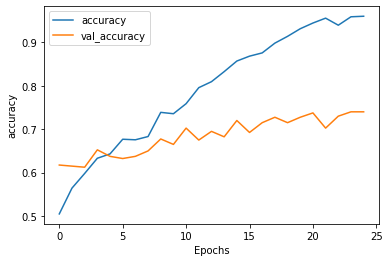

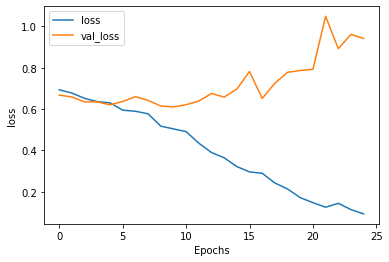

In [ ]:
#plot accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model_noGlove = Sequential()
#Non-trainable embeddidng layer
model_noGlove.add(Embedding(vocab_size+1,50,input_length=max_length))
#LSTM 
model_noGlove.add(LSTM(units=128))
model_noGlove.add(Dense(1, activation='sigmoid'))
model_noGlove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history_noGlove = model_noGlove.fit(X_train, y_train, validation_data = (X_test,y_test) , epochs=5) 

#DistilBert

In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 174kB/s 
     |████████████████████████████████| 6.8MB 36.8MB/s 
     |████████████████████████████████| 983kB 48.5MB/s 
     |████████████████████████████████| 266kB 48.5MB/s 
     |████████████████████████████████| 1.9MB 28.6MB/s 
     |████████████████████████████████| 1.2MB 45.4MB/s 
     |████████████████████████████████| 471kB 45.6MB/s 
     |████████████████████████████████| 890kB 41.1MB/s 
     |████████████████████████████████| 3.2MB 31.1MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.0-cp37-none-any.whl size=25276917 sha256=d7e3542d940c02c30fb55453e04d9fd9a538471c3c53787a5d92039cbb9583c5
  Stored in directory: /root/.cache/pip/wheels/fc/e5/c7/c17fc12743a31df1deacb71ce327f946528774d494d3038995
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=83965be6ea9ddbe770fc96b694894e2baad4830932a6d3e3e0943a0b8b1ef3ce
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [ ]:
bertdf = smallerdf.reset_index(drop=True)
contentbert = bertdf.drop(['Polarity',	'Subjectivity', 'Reliability'],axis=1)

In [ ]:
cleantext = bertdf['content'].apply(rem_noise)

In [ ]:
x_bert = np.asarray(cleantext)
y_bert = np.asarray(bertdf["Reliability"])

In [ ]:
y_bert

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_bert,y_bert,test_size=0.20,random_state=1)

In [ ]:
y_train

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=[0, 1])
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


preprocessing train...
language: en
train sequence lengths:
	mean : 408
	95percentile : 976
	99percentile : 1475


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 430
	95percentile : 1033
	99percentile : 1691


In [ ]:
learner.fit_onecycle(5e-3, 3)



begin training using onecycle policy with max lr of 0.005...
Epoch 1/3
 60/267 [=====>........................] - ETA: 1:03:01 - loss: 0.7175 - accuracy: 0.5556

KeyboardInterrupt: ignored

In [ ]:
learner.validate(class_names=[0, 1])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.predict(X_test[20])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.predict(X_test[20])